In [17]:
import numpy as np
# Autoreload
%load_ext autoreload
%autoreload 2

# Imports
import matplotlib.pyplot as plt
import pandas as pd

from ecodynelec.parameter import Parameter  # Import the class to manipulate parameters
from etude_stat.analysis_functions import generate_data, load_data
from etude_stat.analysis_functions import format_data_0

# Basic configuration
my_config = Parameter()
my_config.freq = "H"
my_config.ctry = ['AT', 'CH', 'DE', 'FR', 'IT']
my_config.target = ['CH', 'AT', 'FR', 'DE']
my_config.data_cleaning = True
my_config.path.generation = "./test_data/downloads/generations/"
my_config.path.exchanges = "./test_data/downloads/exchanges/"
my_config.residual_global = False
my_config.residual_local = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
#### 1.1 Download and generate data files
# This can done once, then the electrical mix and impact files will be saved and can be loaded directly (see 1.2)
years = ['2016', '2017', '2018', '2019', '2020', '2021']
raws, mixs, impacts = generate_data(my_config, years)

In [18]:
years = ['2016', '2017', '2018', '2019', '2020', '2021']
raws, mixs, impacts = load_data(my_config, years)

In [19]:
raw_productions = {}
electricity_mixs = {}
electricity_impacts = {}
producing_electricity_impacts = {}
for c in my_config.target:
    raw_productions[c] = format_data_0({y: raws[y][c] for y in years})
    electricity_mix = format_data_0({y: mixs[y][c] for y in years})
    electricity_impact = format_data_0({y: impacts[y][c] for y in years})
    producing_electricity_impact = electricity_impact['df'] / electricity_mix['df']
    electricity_mixs[c] = electricity_mix
    electricity_impacts[c] = {k: v * 1000 for k, v in electricity_impact.items()}  # convert kgCO2eq/kWh -> gCO2eq/kWh
    producing_electricity_impacts[c] = producing_electricity_impact * 1000  # convert kgCO2eq/kWh -> gCO2eq/kWh


GWP mixs conso et import vers CH vs temps

In [20]:
ordered_countries = ['CH', 'DE', 'FR', 'AT', 'IT', 'Other']
colormap = {
    'sum': 'lightgray',
    'CH': '#1f77b4',
    'DE': '#c62728',
    'FR': '#2ca02c',
    'IT': '#9467bd',
    'AT': '#ff7f0e',
    'Other': '#e377c2'
}
ordered_colors = [colormap[c] for c in ordered_countries]

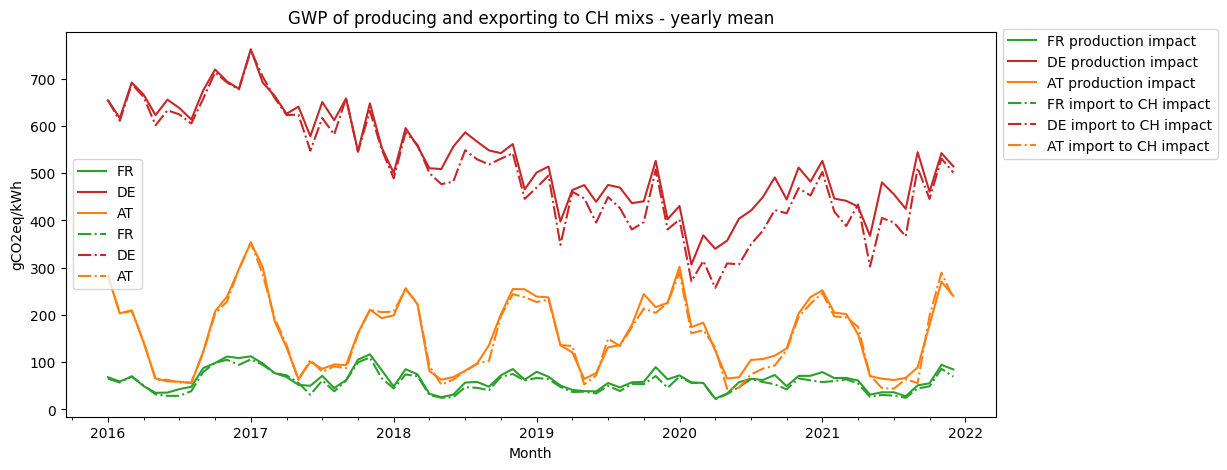

In [30]:
countries = ['FR', 'DE', 'AT']

table = {}
fig, ax = plt.subplots(figsize=(12, 5))
for c in countries:
    table[c + '_prod'] = producing_electricity_impacts[c][c].resample('M').mean()
    table[c + '_prod'].plot(style='-', legend=True, color=colormap[c])
for c in countries:
    emitted_co2 = producing_electricity_impacts[c][c].multiply(raw_productions['CH']['df'][c])
    emitted_co2 = emitted_co2.resample('M').sum() / raw_productions['CH']['df'][c].resample('M').sum()
    emitted_co2.plot(style='-.', legend=True, color=colormap[c])
    table[c + '_import'] = emitted_co2
ax.set_title('GWP of producing and exporting to CH mixs - yearly mean')
ax.set_xlabel('Month')
ax.set_ylabel('gCO2eq/kWh')
# Add margin on x axis
x0, x1 = plt.xlim()
plt.xlim(x0 - 0.05 * (x1 - x0), x1 + 0.05 * (x1 - x0))
fig.legend(
    np.concatenate([[f'{c} production impact' for c in countries], [f'{c} import to CH impact' for c in countries]]),
    loc='upper left', bbox_to_anchor=(0.9, 0.9));

In [28]:
tabled = pd.DataFrame(table)
for c in countries:
    tabled[c + '_diff'] = (tabled[c + '_import'].astype(float) - tabled[c + '_prod'].astype(float)) / tabled[
        c + '_prod'].astype(float) * 100
tabled = tabled.applymap(lambda val: f'{val:.2f}').T
ordered_table = tabled.loc[['AT_prod', 'AT_import', 'AT_diff', 'FR_prod', 'FR_import', 'FR_diff', 'DE_prod', 'DE_import', 'DE_diff']]
ordered_table.index = ['AT production mix impact', 'Impact of AT electricity consumed in CH', 'Difference (%)', 'FR production mix impact', 'Impact of FR electricity consumed in CH', 'Difference (%)', 'DE production mix impact', 'Impact of DE electricity consumed in CH', 'Difference (%)']

In [29]:
ordered_table

,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31
AT production mix impact,161.92,164.14,159.15,166.92,151.23,154.76
Impact of AT electricity consumed in CH,164.79,167.20,187.44,170.02,150.31,177.38
Difference (%),1.77,1.86,17.78,1.86,-0.61,14.62
FR production mix impact,67.92,78.30,56.72,57.39,57.62,57.44
Impact of FR electricity consumed in CH,65.04,78.90,52.84,48.63,52.82,50.89
Difference (%),-4.24,0.77,-6.83,-15.26,-8.33,-11.41
DE production mix impact,660.71,635.64,541.26,461.42,417.65,469.35
Impact of DE electricity consumed in CH,664.43,634.03,525.96,435.34,379.18,458.74
Difference (%),0.56,-0.25,-2.83,-5.65,-9.21,-2.26


GWP émission carbone producteur vs taux d'import en Suisse

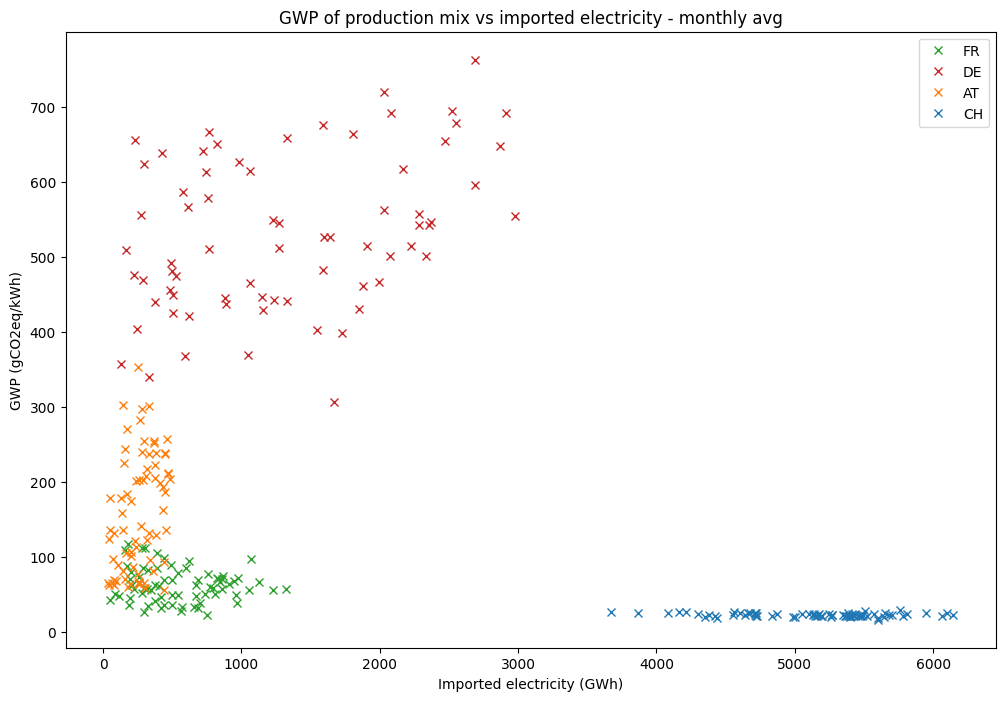

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.linspace(0, 1, 100)
countries.append('CH')
for c in countries:
    #mx = electricity_mixs['CH']['df'][c].resample('M').mean()
    mx = raw_productions['CH']['df'][c].resample('M').mean()
    px = producing_electricity_impacts[c][c].resample('M').mean()
    plt.plot(mx,px, color=colormap[c], label=c, marker='x', linestyle='None')
plt.title('GWP of production mix vs imported electricity - monthly avg')
plt.xlabel('Imported electricity (GWh)')
plt.ylabel('GWP (gCO2eq/kWh)')
plt.legend();

Comparaison des impacts producteurs selon la méthode de calcul :

In [49]:
def get_gwp_in_date_range(year_start, year_end, study_start, study_end, country):
    prod_impact = producing_electricity_impacts[country].loc[year_start:year_end][country]
    prod_impact_yearly = prod_impact.mean()
    prod = raw_productions[country]['df'].loc[study_start:study_end][country]
    total_prod = prod.sum()
    emitted_avg = prod * prod_impact_yearly  # in kgCO2eq (prod is MWh, prod_impact is gCO2eq/kWh)
    emitted_hourly = prod.multiply(prod_impact)  # in kgCO2eq (prod is MWh, prod_impact is gCO2eq/kWh)
    return (prod_impact_yearly, total_prod, emitted_avg, emitted_hourly,
            prod_impact)  # (yearly impact kgCO2eq/MWh, total_prod MWh, total emissions kgCO2eq/hour avg, total emissions kgCO2eq/hour hourly, hourly impact kgCO2eq/MWh)

-----CH-----
Total production in period: 45405158.96 MWh
Total emissions in period (avg estimate): 1014610371.77 tCO2eq. 22.35 kgCO2eq/MWh
Total emissions in period (hourly estimate): 1049237994.88 tCO2eq. 23.11 kgCO2eq/MWh
-----FR-----
Total production in period: 514053575.99 MWh
Total emissions in period (avg estimate): 29528319037.85 tCO2eq. 57.44 kgCO2eq/MWh
Total emissions in period (hourly estimate): 30754043524.88 tCO2eq. 59.83 kgCO2eq/MWh
-----DE-----
Total production in period: 505039468.50 MWh
Total emissions in period (avg estimate): 237041522608.40 tCO2eq. 469.35 kgCO2eq/MWh
Total emissions in period (hourly estimate): 233839214963.51 tCO2eq. 463.01 kgCO2eq/MWh


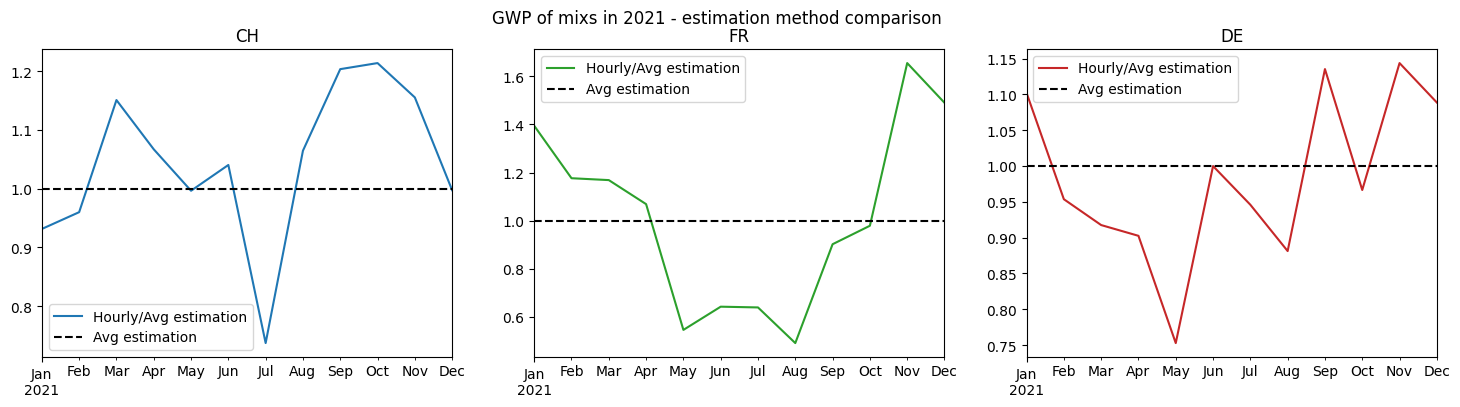

In [68]:
y_start = '2021-01-01 00:00'
y_end = '2021-12-31 23:59'
start = '2021-01-01 00:00'
end = '2021-12-31 23:59'
countries = ['CH', 'FR', 'DE']

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
for i in range(len(countries)):
    c = countries[i]
    (prod_impact_yearly, total_prod, emitted_avg, emitted_hourly, impact_hourly) = get_gwp_in_date_range(y_start, y_end,
                                                                                                         start, end, c)
    print('-----' + c + '-----')
    #print(f'GWP of mix in 2021: {prod_impact_yearly:.2f} gCO2eq/kWh')
    print(f'Total production in period: {total_prod:.2f} MWh')
    print(
        f'Total emissions in period (avg estimate): {emitted_avg.sum():.2f} tCO2eq. {emitted_avg.sum() / total_prod:.2f} kgCO2eq/MWh')
    print(
        f'Total emissions in period (hourly estimate): {emitted_hourly.sum():.2f} tCO2eq. {emitted_hourly.sum() / total_prod:.2f} kgCO2eq/MWh')

    #emitted_avg.resample('M').mean().plot(color=colormap[c], ax=ax[i], linestyle='--')
    #emitted_hourly.resample('M').mean().plot(color=colormap[c], ax=ax[i])
    #ax[i].axhline(y=prod_impact_yearly, color=colormap[c], )
    #ax[i].legend([f'{c} hourly emissions - ', f'{c} emissions - avg on year'])
    # if c == 'DE':
    #     ax[i].set_ylim(350, 550)
    # else:
    #     ax[i].set_ylim(0, 200)

    # ax[i].scatter(emitted_avg.resample('M').mean()/1000, emitted_hourly.resample('M').mean()/1000, color=colormap[c], marker='o')
    # ax[i].set_xlabel('Total emissions (avg estimate) (tCO2eq/month)')
    # ax[i].set_ylabel('Total emissions (hourly estimate) (tCO2eq/month)')
    # ax[i].legend([f'{c}'])

    ratio = emitted_hourly.resample('M').mean().divide(emitted_avg.resample('M').mean())
    ratio.plot(color=colormap[c], ax=ax[i])
    ax[i].axhline(y=1, color='black', linestyle='--')
    ax[i].set_title(f'{c}')
    ax[i].legend([f'Hourly/Avg estimation', 'Avg estimation'])
fig.suptitle('GWP of mixs in 2021 - estimation method comparison');

GPW mix producteur et consommateur VS part de bas-carbone

In [126]:
b = raw_productions['FR']['raw_df'].columns
b = [c for c in b if c.endswith('FR')]
b

['Biomass_FR',
 'Fossil_Brown_coal/Lignite_FR',
 'Fossil_Coal-derived_gas_FR',
 'Fossil_Gas_FR',
 'Fossil_Hard_coal_FR',
 'Fossil_Oil_FR',
 'Fossil_Oil_shale_FR',
 'Fossil_Peat_FR',
 'Geothermal_FR',
 'Hydro_Pumped_Storage_FR',
 'Hydro_Run-of-river_and_poundage_FR',
 'Hydro_Water_Reservoir_FR',
 'Marine_FR',
 'Nuclear_FR',
 'Other_fossil_FR',
 'Other_renewable_FR',
 'Solar_FR',
 'Waste_FR',
 'Wind_Offshore_FR',
 'Wind_Onshore_FR']

In [160]:
cls = ['Fossil_Gas_FR']
raw_productions['CH']['raw_df'][cls].sum().sum()

386586.8

In [110]:
b = electricity_mixs['FR']['raw_df'].columns
b = [c for c in b if c.endswith('FR')]
b

['Biomass_FR',
 'Fossil_Brown_coal/Lignite_FR',
 'Fossil_Coal-derived_gas_FR',
 'Fossil_Gas_FR',
 'Fossil_Hard_coal_FR',
 'Fossil_Oil_FR',
 'Fossil_Oil_shale_FR',
 'Fossil_Peat_FR',
 'Geothermal_FR',
 'Hydro_Pumped_Storage_FR',
 'Hydro_Run-of-river_and_poundage_FR',
 'Hydro_Water_Reservoir_FR',
 'Marine_FR',
 'Nuclear_FR',
 'Other_fossil_FR',
 'Other_renewable_FR',
 'Solar_FR',
 'Waste_FR',
 'Wind_Offshore_FR',
 'Wind_Onshore_FR']

In [136]:
fossil_sources = ['Fossil_Brown_coal/Lignite',
                  'Fossil_Coal-derived_gas',
                  'Fossil_Gas',
                  'Fossil_Hard_coal',
                  'Fossil_Oil',
                  'Fossil_Oil_shale',
                  'Fossil_Peat',
                  'Other_fossil']

In [143]:
fossil_shares = {c: (electricity_mixs[c]['raw_df'][[f'{src}_{c}' for src in fossil_sources]]
                     .sum(axis=1) / electricity_mixs[c]['df'][c]).mean(axis=0) for c in my_config.target}
fossil_shares

{'CH': 0.0,
 'FR': 0.07462345446119709,
 'DE': 0.3689397331395829,
 'AT': 0.16123851317779858}

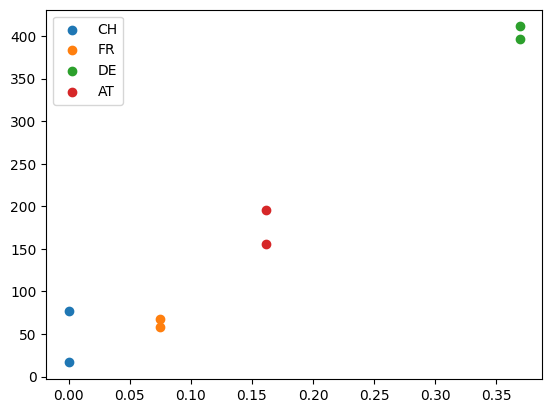

In [156]:
for c in my_config.target:
    plt.scatter([fossil_shares[c], fossil_shares[c]],
                [producing_electricity_impacts[c][c].mean(axis=0),
                 electricity_impacts[c]['df']['sum'].mean(axis=0) * 1000], label=c)
plt.legend();